In [2]:
import os
import numpy as np
import pandas as pd
from skimage.util.montage import montage2d
import matplotlib.pyplot as plt
%matplotlib inline
base_path = os.path.join('..', 'Data')
import cv2

# IceBerg Classifier
## 背景
数据由Sentinel-1卫星获得，卫星雷达与地面雷达相似，先发送脉冲，记录下物体反射的脉冲信号并转化为图像。一个物体会成为亮点是因为它反射的能量比周围的要多，固体（比如船只，冰山，岛屿）反射的能量比较大。反射会雷达的能量成为后向散射。
当雷达探测到一个物体时，无法辨别冰山和船只，需要分析某些特征（亮度，大小，形状）才能进一步确认。很多因素都会影响雷达的后向散射，比如强风会产生更加明亮的背景，弱分会产生更暗的背景。Sentinel-1卫星是侧视卫星，以为着它会以一个角度（入射角， incidence angle）查看图像区域。通常情况下，海洋背景会变得更暗在更高的入射角。此外，雷达的极化也是需要考虑的因素，Sentinel-1卫星可以在水平和垂直平面发送和接收，这样可以得到双偏正图像。
在这个比赛中，数据有两个通道：HH（水平发送，水平接收）和 HV（水平发送，垂直接收），由于对象反射不同的能量，在物体识别过程中会起很大作用。

1、HV的后向散射相比于HH要弱，且容易受噪声影响。
2、对于HH模式，入射角的提高可以提高探测冰山的成功率

In [3]:
def load_and_format(in_path):
    out_df = pd.read_json(in_path)
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).squeeze()
    return out_df, out_images

In [4]:
train_df, train_images = load_and_format('../Data/train.json')
train_df['inc_angle'] = pd.to_numeric(train_df['inc_angle'],errors='coerce')
print('training', train_df.shape, 'loaded', train_images.shape)

training (1604, 5) loaded (1604, 75, 75, 2)


In [6]:
img = train_images[5,:,:,0]
print(img)


[[-20.769371 -20.769434 -25.906025 ..., -17.567146 -20.468288 -23.481234]
 [-20.769371 -21.247677 -21.413191 ..., -18.007032 -19.889076 -21.93305 ]
 [-22.108368 -21.581852 -20.464762 ..., -21.932987 -23.481295 -21.93305 ]
 ..., 
 [-20.618214 -21.756374 -22.866783 ..., -20.93218  -20.932243 -21.419491]
 [-20.318735 -19.085659 -22.866783 ..., -19.615896 -20.470936 -21.419491]
 [-20.172749 -17.45956  -20.318861 ..., -18.962515 -20.932304 -22.870569]]


In [6]:
test_df, test_images = load_and_format('Data/test.json')
print('testing', test_df.shape, 'loaded', test_images.shape)

testing (8424, 4) loaded (8424, 75, 75, 2)


In [7]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    #train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    #train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    #train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train_df['num_p75' + str(label)] = [np.sum(np.array(x) > np.sort(np.array(x))[int(0.75*75*75)]) for x in train_df['band_'+str(label)]]
    #train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]
    return train

In [17]:
train_df = get_stats(train_df,label=1)
train_df = get_stats(train_df,label=2)
train_df.head(5)

,band_1,band_2,id,inc_angle,is_iceberg,num,max1,min1,std1,mean1,p25_1,p75_1,num_p751,max2,min2,std2,mean2,p25_2,p75_2,num_p752
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0,1404,-0.213149,-38.211376,2.764537,-27.911043,-29.539108,-26.487118,1404,-11.252153,-41.135918,2.381284,-29.910117,-31.591387,-28.267622,1405
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0,1406,12.570409,-23.125309,3.142532,-13.566554,-15.333844,-12.128263,1406,0.044052,-34.765831,2.934098,-25.359106,-26.963490,-23.997253,1405
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1,1403,-9.918477,-33.391197,2.223905,-23.053698,-24.604092,-21.533882,1403,-15.605879,-34.148819,2.125275,-24.839821,-26.033436,-23.379602,1404
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0,1405,4.795627,-32.204136,2.566233,-23.210771,-24.754293,-21.870052,1405,-5.554516,-39.564053,2.389980,-29.567913,-31.042850,-28.276203,1404
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0,1406,-6.956036,-35.010487,2.305288,-25.280029,-26.591318,-23.796333,1406,-9.434006,-40.276115,2.276244,-25.627726,-26.895178,-24.017248,1405


In [14]:
train_df['num'] = [np.sum(np.array(x) > np.sort(np.array(x))[int(0.75*75*75)]) for x in train_df['band_1']]

In [18]:
def plot_scatter(var1, var2):
    #画散点图
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 6))
    
    ax1.scatter(train_df.loc[train_df.is_iceberg==1, var1 ], train_df.loc[train_df.is_iceberg==1, var2+str(1)], label='iceberg')
    ax1.scatter(train_df.loc[train_df.is_iceberg==0, var1], train_df.loc[train_df.is_iceberg==0,  var2+str(1)], label='ship')
    ax1.legend(loc = 'best')
    ax1.set_title('Band1: releatiship between '+var1+ ' and '+ var2)
    ax1.set_xlabel(var1)
    ax1.set_ylabel(var2+str(1))
    ax2.scatter(train_df.loc[train_df.is_iceberg==1, var1], train_df.loc[train_df.is_iceberg==1,  var2+str(2)], label='iceberg')
    ax2.scatter(train_df.loc[train_df.is_iceberg==0, var1], train_df.loc[train_df.is_iceberg==0,  var2+str(2)], label='ship')
    ax2.legend(loc = 'best')
    ax2.set_title('Band 2: releatiship between '+ var1 + ' and '+ var2)
    ax2.set_xlabel(var1)
    ax2.set_ylabel(var2+str(2))

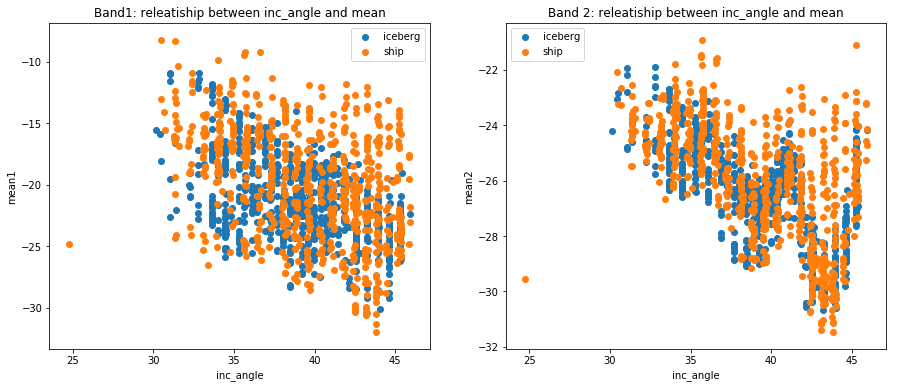

In [19]:
plot_scatter('inc_angle', 'mean')

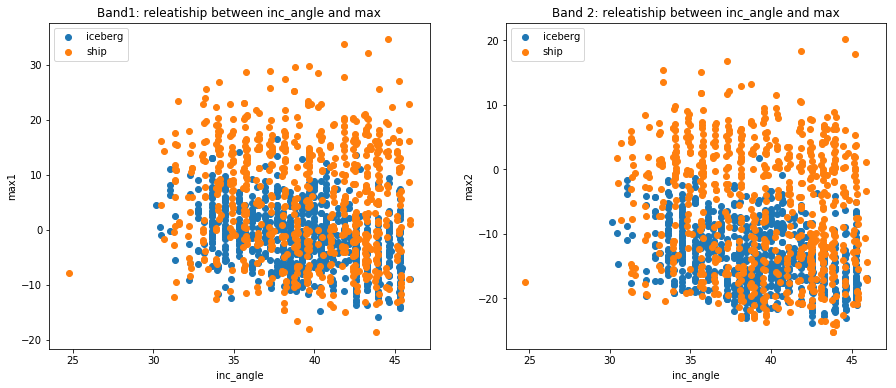

In [70]:
plot_scatter('inc_angle', 'max')

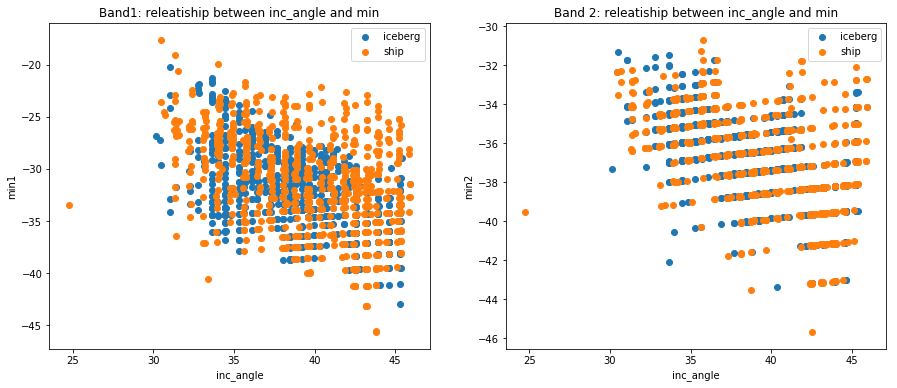

In [107]:
plot_scatter('inc_angle', 'max')

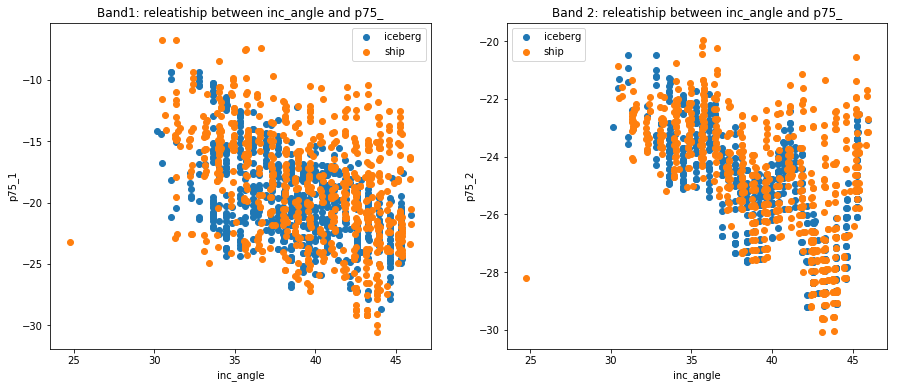

In [109]:
plot_scatter('inc_angle', 'p75_')

In [ ]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

Mean of band1:  -19.999607634 Var of band1:  11.0534587259
Mean of band2:  -27.0982036946 Var of band2:  7.67792451829


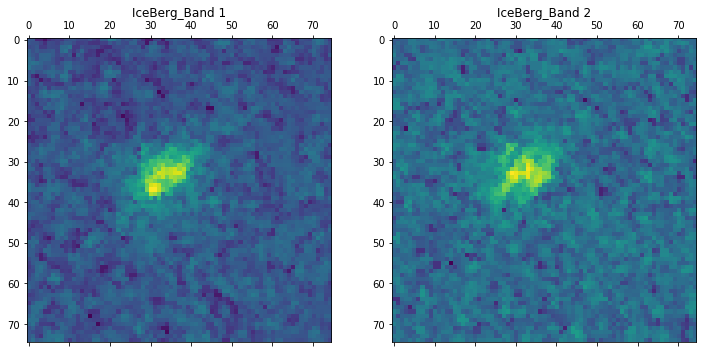

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.matshow(train_images[5,:,:,0])
ax1.set_title('IceBerg_Band 1')
ax2.matshow(train_images[5,:,:,1])
ax2.set_title('IceBerg_Band 2')
print('Mean of band1: ',np.mean(train_images[5,:,:,0]), 'Var of band1: ', np.var(train_images[5,:,:,0]))
print('Mean of band2: ',np.mean(train_images[5,:,:,1]), 'Var of band2: ', np.var(train_images[5,:,:,1]))

Mean of band1:  -13.5665537141 Var of band1:  9.87550492641
Mean of band2:  -25.359106349 Var of band2:  8.6089302814


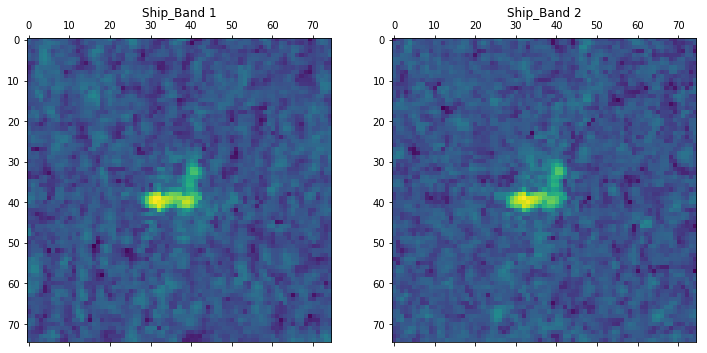

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))
ax1.matshow(train_images[1,:,:,0])
ax1.set_title('Ship_Band 1')
ax2.matshow(train_images[1,:,:,1])
ax2.set_title('Ship_Band 2')
print('Mean of band1: ',np.mean(train_images[1,:,:,0]), 'Var of band1: ', np.var(train_images[1,:,:,0]))
print('Mean of band2: ',np.mean(train_images[1,:,:,1]), 'Var of band2: ', np.var(train_images[1,:,:,1]))

In [20]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(train_images[5,:,:,0], 'iceberg_band1')

In [21]:
plotmy3d(train_images[5,:,:,1], 'iceberg_band2')

In [37]:
plotmy3d(train_images[1,:,:,0], 'ship_band1')

In [38]:
plotmy3d(train_images[1,:,:,1], 'iceberg_band2')